In [2]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics
using Flight.FlightComponents
using Flight.FlightAircraft.C172FBW
using Flight.FlightAircraft.C172

using UnPack
using ControlSystems
using RobustAndOptimalControl
using ComponentArrays
using LinearAlgebra

In [16]:
ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics

#use default trim condition
design_point = C172.TrimParameters()

P_lss_lon = Control.LinearStateSpace(ac, design_point; model = :lon);
P_nss_lon = named_ss(P_lss_lon);

x_labels_lon = keys(P_lss_lon.x0) |> collect
y_labels_lon = keys(P_lss_lon.y0) |> collect
u_labels_lon = keys(P_lss_lon.u0) |> collect
x_labels = deleteat!(x_labels_lon, findfirst(isequal(:h), x_labels_lon))
y_labels = deleteat!(y_labels_lon, findfirst(isequal(:h), y_labels_lon))
u_labels = u_labels_lon
# x_labels = x_labels_lon
# y_labels = y_labels_lon
# u_labels = u_labels_lon

P_lss = submodel(P_lss_lon; x = x_labels, u = u_labels, y = y_labels)
P_nss = named_ss(P_lss);

39.99999999999999

## 1. Longitudinal Dynamics Regulator

In [4]:
dampreport(P_nss_lon)
dampreport(P_nss)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+


| -0.000369          |  1            |  0.000369     |  5.87e-05     |  2.71e+03     |


| -0.0176 ±  0.293im |  0.0601       |  0.293        |  0.0467       |  56.8         |
| -4.42   ±   5.14im |  0.652        |  6.78         |  1.08         |  0.226        |
| -9.72              |  1            |  9.72         |  1.55         |  0.103        |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -48.1              |  1            |  48.1         |  7.65         |  0.0208       |
|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.0178 ±  0.291im |  0.061        |  0.292        |  0.0465       |  56.2         |
| -4.42   ±   5.14im |  0.652        |  6.78         |  1.08         |  0.226        |
| -9.72              |  1            |  9.7

We see that removing $h$ as a state eliminates an extremely slow pole, probably related to the effect of altitude on engine output. The remaining poles are virtually unaffected. Also, it significantly improves the condition of the dynamics matrix:

In [5]:
cond(P_nss_lon.A) |> display
cond(P_nss.A) |> display

7.656238481914343e7

440485.80842732603

But a much more important reason for removing $h$ is that, even if the dynamics matrix is still invertible, the block $H_x F^{-1} G$ in the feedforward gain matrix required for $\theta$ and $EAS$ tracking is not. This is perfectly understandable: we cannot have an arbitrary combination of $\theta$ and $EAS$ and still maintain constant altitude. In other words, keeping $h$ in the state vector produces quasi-static rather than static equilibrium, and therefore we would need partitioning the state to handle it. Note that this issue is only related to the selection of the command variables $\theta$ and $EAS$, not to the system's dynamics. If we picked instead $h$ and $EAS$, we could have true static equilibrium. Thus, for this design we will use the MIMO system without $h$ as our plant baseline. Let's start by designing a full-state feedback regulator for the MIMO system.

In [6]:
controllability(P_nss)

(iscontrollable = true, ranks = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10], sigma_min = [0.0026382090058166643, 1.2392048041221948, 1.2392048041221948, 1.2392048041221948, 1.2392048041221948, 0.4879588010303914, 0.4425611178586627, 0.4425611178586627, 0.040256617772433265, 0.040256617772433265])

In [7]:
@unpack x0, u0 = P_lss
@unpack v_x, v_z = x0
v_norm = norm([v_x, v_z])

#the states we care about are q, θ, v_x, v_z (equivalent to V and α)
diagQ = ComponentVector(q = 1, θ = 5, v_x = 1/v_norm, v_z = 1/v_norm, α_filt = 0, ω_eng = 0, ele_v = 0, ele_p = 0, thr_v = 0, thr_p = 0)
diagR = ComponentVector(elevator_cmd = 0.1, thr_cmd = 1)
Q = ComponentMatrix(diagm(diagQ), Axis(x_labels), Axis(x_labels))
R = ComponentMatrix(diagm(diagR), Axis(x_labels), Axis(x_labels))

#feedback gain matrix
C_fbk = lqr(P_nss, Q, R)
display(C_fbk)

C_fbk_ss = named_ss(ss(C_fbk); u = x_labels, y = [:elevator_fbk, :throttle_fbk])

elevator_sum = sumblock("elevator_cmd = elevator_fwd - elevator_fbk")
throttle_sum = sumblock("throttle_cmd = throttle_fwd- throttle_fbk")
connections = vcat(Pair.(x_labels, x_labels), Pair.(u_labels, u_labels), Pair.(C_fbk_ss.y, C_fbk_ss.y))

P_nss_fbk = connect([elevator_sum, throttle_sum, P_nss, C_fbk_ss], connections; w1 = [:elevator_fwd, :throttle_fwd], z1 = vcat(y_labels, u_labels))

dampreport(P_nss) |> display
dampreport(P_nss_fbk) |> display

2×10 Matrix{Float64}:
 2.67697     9.33721   -0.313308   -0.113734   …  -0.0003892    -0.00876201
 0.0423061  -0.409397   0.0851077   0.0103107      0.000188442   0.00712911

nothing

nothing

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.0178 ±  0.291im |  0.061        |  0.292        |  0.0465       |  56.2         |
| -4.42   ±   5.14im |  0.652        |  6.78         |  1.08         |  0.226        |
| -9.72              |  1            |  9.72         |  1.55         |  0.103        |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -48.1              |  1            |  48.1         |  7.65         |  0.0208       |
|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+-----

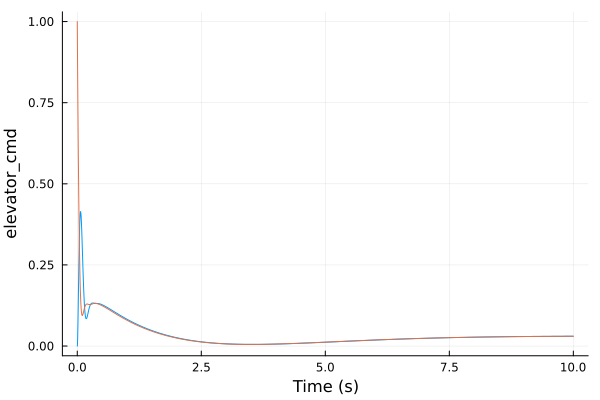

In [8]:
# e2q = P_nss[:q, :elevator_cmd]
# e2q_fbk = P_nss_fbk[:q, :elevator_fwd]
# step(e2q, 10) |> plot
# step(e2q_fbk, 10) |> plot!

# e2θ = P_nss[:θ, :elevator_cmd]
# e2θ_fbk = P_nss_fbk[:θ, :elevator_fwd]
# step(e2θ, 10) |> plot
# step(e2θ_fbk, 10) |> plot!

e2e_fbk = P_nss_fbk[:ele_p, :elevator_fwd]
e2p_fbk = P_nss_fbk[:elevator_cmd, :elevator_fwd]
step(e2e_fbk, 10) |> plot
step(e2p_fbk, 10) |> plot!

# t2v_fbk = P_nss_fbk[:EAS, :throttle_fwd]
# t2v_fbk = P_nss_fbk[:EAS, :throttle_fwd]
# t2t_fbk = P_nss_fbk[:throttle_cmd, :throttle_fwd]
# t2θ_fbk = P_nss_fbk[:θ, :throttle_fwd]

# step(t2v, 20) |> plot
# step(t2v_fbk, 20) |> plot
# step(t2t_fbk, 20) |> plot!
# step(t2θ_fbk, 20) |> plot!

## 2. $\theta$ + $EAS$ Tracker

Now, we determine the feedforward gain matrix for tracking $\theta$ and $EAS$. Following Stengel section 6.2:

In [9]:
F = P_lss.A
G = P_lss.B
n_x, n_u = size(G) #number of states and control inputs

H_x = P_lss.C[(:θ, :EAS), :]
n_y = size(H_x)[1] #number of selected command inputs (must be n_y ≤ n_u)

H_u = zeros(n_y, n_u)

A = [F G; H_x H_u]
B = inv(A)
display(B)
B_12 = B[1:n_x, n_x+1:end]
B_22 = B[n_x+1:end, n_x+1:end]
C_fwd = B_22 + C_fbk * B_12
C_fwd_ss = named_ss(ss(C_fwd), u = [:θ_dmd, :EAS_dmd], y = [:elevator_fwd, :throttle_fwd])

12×12 Matrix{Float64}:
  3.46945e-16   1.0           1.99493e-17  …    2.17834e-14  -1.65667e-7
 -6.93889e-18  -5.55112e-17  -2.77556e-17       1.0           0.0
 -0.0123956    -1.76216       0.00234786        0.0525006     1.06744
  0.171668     24.4043       -0.0325155        -0.727083     -0.207229
  0.00409898    0.58271      -0.000776387      -0.0173609    -0.00675327
 34.9393       57.0646       52.9209       …  517.996         4.66582
  0.0          -0.0           0.0              -0.0           0.0
  0.109722      2.68127      -0.0216477        -0.249868     -0.0261003
  0.0          -0.0           0.0              -0.0           0.0
  0.295535      0.469212      0.447632          4.38147       0.0187588
  0.109722      2.68127      -0.0216477    …   -0.249868     -0.0261003
  0.295535      0.469212      0.447632          4.38147       0.0187588

NamedStateSpace{Continuous, Float64}
D = 
 8.674711675349512  -0.4099067998683834
 4.085479239476279   0.10851812756644162

Continuous-time state-space model
With state  names: 
     input  names: θ_dmd EAS_dmd
     output names: elevator_fwd throttle_fwd


In [10]:
connections = Pair.(C_fwd_ss.y, C_fwd_ss.y)
P_nss_fbk_θv = connect([C_fwd_ss, P_nss_fbk], connections; w1 = [:θ_dmd, :EAS_dmd], z1 = P_nss_fbk.y)

NamedStateSpace{Continuous, Float64}
A = 
    -4.0938788989315364     -3.6584495396452255e-6     0.25031057566678244     -3.6930629519106994       118.74578120872768    0.00331829379055371     0.0                      9.427519146233827     0.0                     0.0
     0.9999987141015481     -2.2301240673189465e-14    1.5740709684208347e-7    1.1365923104129316e-8      0.0                 0.0                     0.0                      0.0                   0.0                     0.0
    -0.4766280149231221     -9.751795990188938        -0.2254621771903162       2.4386931988506797       -74.24918722324715    0.01670297478387908     0.0                     -6.385995985702365     0.0                     0.0
    40.73193514965443       -0.7041396945986307       -0.274283552911747       -2.6548942110426004        26.023429477999827   4.557609538527063e-5    0.0                      3.136085390848322     0.0                     0.0
     0.0                     0.0                      

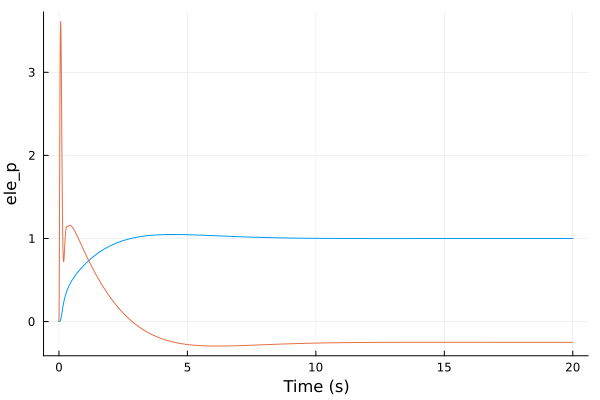

In [11]:
θdmd2θ = P_nss_fbk_θv[:θ, :θ_dmd]
θdmd2e = P_nss_fbk_θv[:ele_p, :θ_dmd]
step(θdmd2θ, 20) |> plot
step(θdmd2e, 20) |> plot!

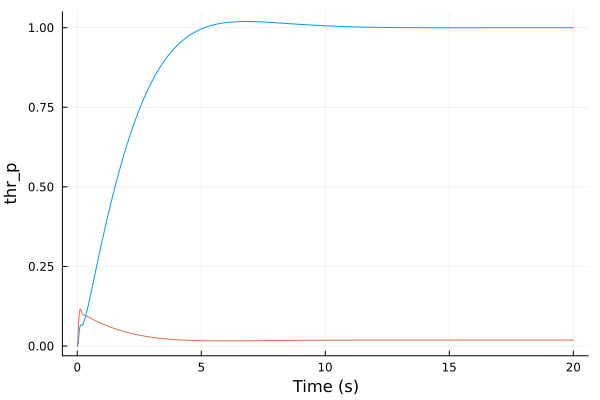

In [12]:
vdmd2v = P_nss_fbk_θv[:EAS, :EAS_dmd]
vdmd2t = P_nss_fbk_θv[:thr_p, :EAS_dmd]
step(vdmd2v, 20) |> plot
step(vdmd2t, 20) |> plot!

## 3. Pitch Rate Tracker

Now, on top of the $\theta$ + $EAS$ tracker we can provide a pitch rate tracker by adding an integrator upstream of the $\theta_{dmd}$ input:

In [13]:
q_int = tf(1, [1, 0])
q_ff = named_ss(q_int |> ss, u = :q_dmd, y = :θ_dmd)
P_nss_fbk_qv = connect([q_ff, P_nss_fbk_θv], [:θ_dmd => :θ_dmd]; w1 = [:q_dmd, :EAS_dmd], z1 = P_nss_fbk_θv.y)
qdmd2q = P_nss_fbk_qv[:q, :q_dmd];

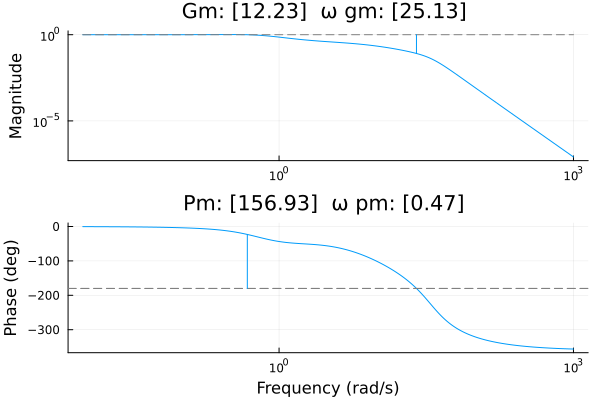

In [14]:
marginplot(qdmd2q)

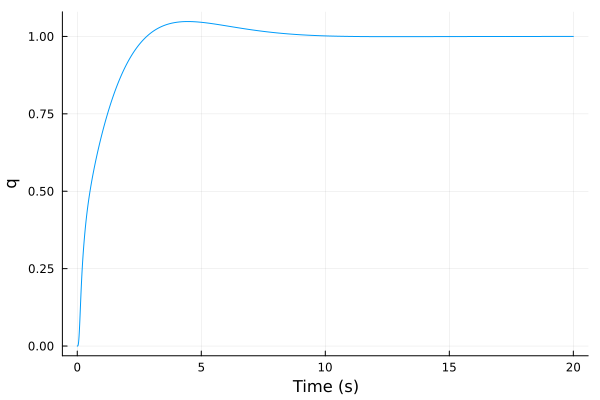

In [15]:
step(qdmd2q, 20) |> plot

In the actual implementation, $\dot{\theta}$ should not be computed directly as $\dot{\theta} = q_{dmd}$ but through the kinematic relation:
$$ q(\dot{\theta}, r, \phi) = \dfrac{1}{\cos \phi}(\dot{\theta} + r \tan \phi) $$
$$ \dot{\theta}_{dmd} = q_{dmd} \cos \phi - r \tan \phi$$